In [4]:
import pandas as pd 
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.stats import zscore
sns.set()

In [5]:
properties = pd.read_csv("properties_v2.csv", sep=",") 
#pd.set_option('display.max_colwidth', None)
#pd.set_option('display.max_columns', None)

In [6]:
properties.describe()
total_properties = properties["price"].count()

In [7]:
def remove_outliers(data, neighbourhood, column, bound_tolerance):
    print(neighbourhood)
    q1, q3 = data.loc[data["neighbourhood"] == neighbourhood, column].quantile([.25,.75])
    iqr = q3-q1
    lb = max(q1 - bound_tolerance*iqr, 0)
    ub = q3 + bound_tolerance*iqr
    print(f"Lower bound: {lb}, upper bound: {ub}")
    len_before = sum(~data.loc[data["neighbourhood"] == neighbourhood, column].isnull())
    data.loc[(data["neighbourhood"]==neighbourhood) & (~data[column].between(lb, ub)), column] = np.nan
    len_after = sum(~data.loc[data["neighbourhood"] == neighbourhood, column].isnull())
    print(f"Removidos {round((1-(len_after/len_before))*100,3)}% dos dados")
    return data

# Removendo bairros de pouca relevância no escopo de dados
Volume menor que 1% dos dados

In [8]:
#for neighbourhood in properties['neighbourhood'].unique():
#    remove_outliers(properties, neighbourhood, "area")
neighbourhood_counts = properties['neighbourhood'].value_counts(normalize=True).to_frame().reset_index()
#print(neighbourhood_counts)
count = 0

neighbourhood_counts

for value in range(len(neighbourhood_counts)):
    count = count + neighbourhood_counts['neighbourhood'].values[value]
    
    if count > 0.99:
        print(neighbourhood_counts['index'].values[value])
        properties = properties.loc[properties['neighbourhood'] != neighbourhood_counts['index'].values[value]]

atuba
santo inacio
cachoeira
tatuquara
umbara
butiatuvinha
cascatinha
augusta
sao joao
campo de santana
riviera
vila oficinas
taboao
caiua
ganchinho
sao miguel
jardim schaffer


# Removendo outliers de preços

(array([-5000.,     0.,  5000., 10000., 15000., 20000., 25000., 30000.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

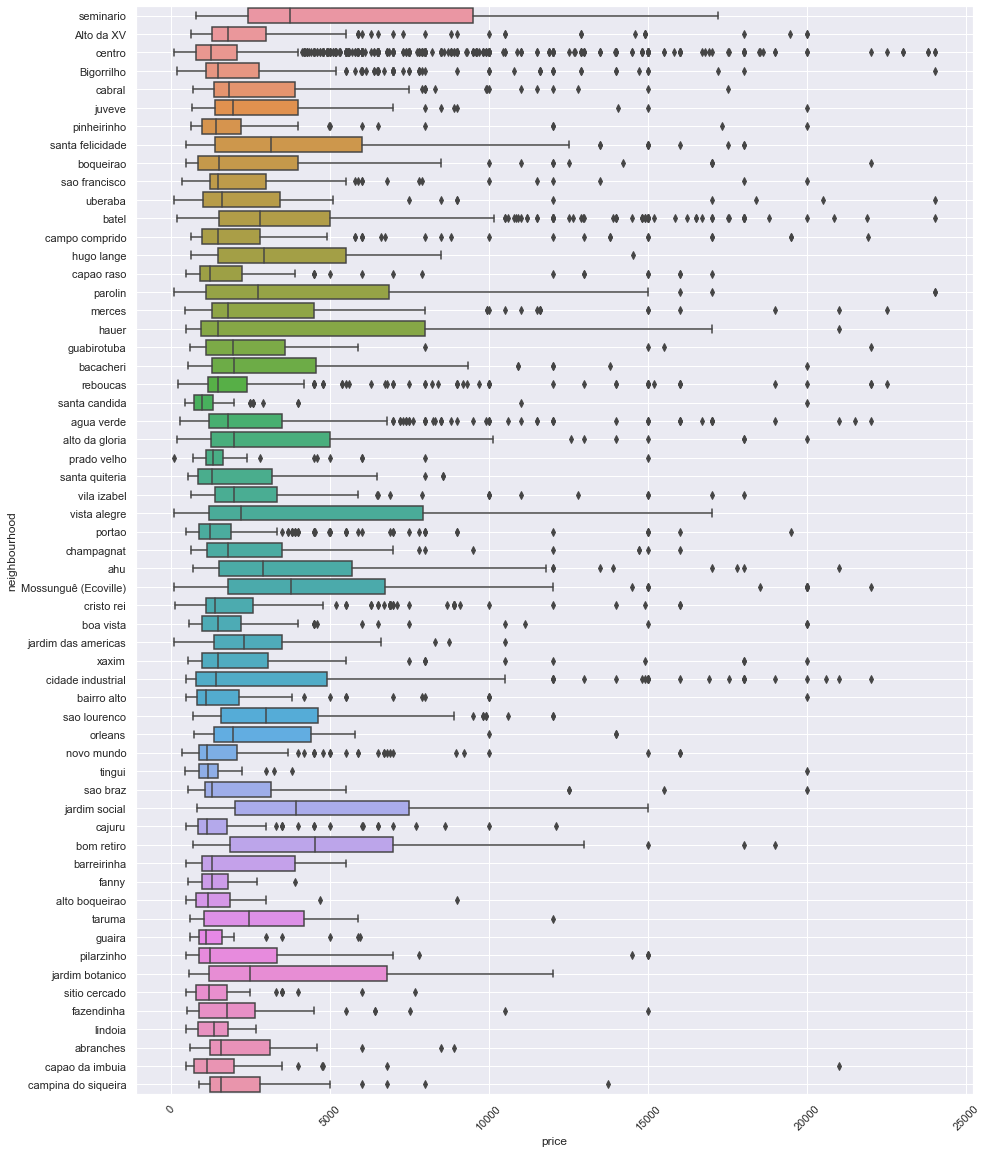

In [17]:
#properties = properties.loc[(properties["price"] >= 500)]
#properties = properties[np.abs(zscore(properties["price"])) < 2]

#properties = properties.loc[properties["area"] != 0]
#properties = properties[np.abs(zscore(properties["area"])) < 2]
#print("Percentual de removidos",round((1-properties["price"].count()/total_properties)*100,3),"%")

#properties["area"].loc[properties["area"] == 0] = np.nan
#properties["price"][np.abs(zscore(properties["price"])) > 2] 

#properties["area"].loc[properties["area"] == 0] = np.nan
#properties["price"][np.abs(zscore(properties["price"])) > 2] = np.nan



#for neighbourhood in properties['neighbourhood'].unique():
#    print(neighbourhood,": ",round(properties["price"][np.abs(zscore(properties["price"])) > 2].loc[properties["neighbourhood"]==neighbourhood].count()/properties["price"].count()*100,3),"%")

#print(round(properties["price"][np.abs(zscore(properties["price"])) > 2].count()/properties["price"].count()*100,3),"%")

#properties["price"][(np.abs(zscore(properties["price"])) < 2)].describe()

properties["price"][np.abs(zscore(properties["price"])) > 1] = np.nan

In [75]:
properties['price'].describe()

count      9790.000000
mean       4018.937692
std       10005.900425
min         100.000000
25%        1000.000000
50%        1500.000000
75%        3400.000000
max      300000.000000
Name: price, dtype: float64

In [70]:
properties['area'].loc[properties['neighbourhood'] == 'prado velho'].describe()
#properties = properties.loc[properties['area'] != 481000.000000 ]

count        62.000000
mean       8100.177419
std       61058.252498
min          17.000000
25%          27.500000
50%          33.500000
75%          74.750000
max      481000.000000
Name: area, dtype: float64

In [28]:
for neighbourhood in properties['neighbourhood'].unique():
    properties = remove_outliers(properties, neighbourhood, 'price', 1)

print("Percentual de removidos",round((1-properties["price"].count()/total_properties)*100,3),"%")

seminario
Lower bound: 0, upper bound: 19500.0
Removidos 2.439% dos dados
Alto da XV
Lower bound: 0, upper bound: 5700.0
Removidos 20.714% dos dados
centro
Lower bound: 0, upper bound: 3750.0
Removidos 15.543% dos dados
Bigorrilho
Lower bound: 0, upper bound: 4500.0
Removidos 15.486% dos dados
cabral
Lower bound: 0, upper bound: 6575.0
Removidos 12.281% dos dados
juveve
Lower bound: 0, upper bound: 6850.0
Removidos 9.375% dos dados
pinheirinho
Lower bound: 0, upper bound: 3600.0
Removidos 12.346% dos dados
santa felicidade
Lower bound: 0, upper bound: 10600.0
Removidos 12.605% dos dados
boqueirao
Lower bound: 0, upper bound: 9312.5
Removidos 14.655% dos dados
sao francisco
Lower bound: 0, upper bound: 4750.0
Removidos 13.38% dos dados
uberaba
Lower bound: 0, upper bound: 6950.0
Removidos 13.274% dos dados
batel
Lower bound: 0, upper bound: 9440.0
Removidos 14.638% dos dados
campo comprido
Lower bound: 0, upper bound: 4710.0
Removidos 21.6% dos dados
hugo lange
Lower bound: 0, upper bou

(array([-2000.,     0.,  2000.,  4000.,  6000.,  8000., 10000., 12000.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

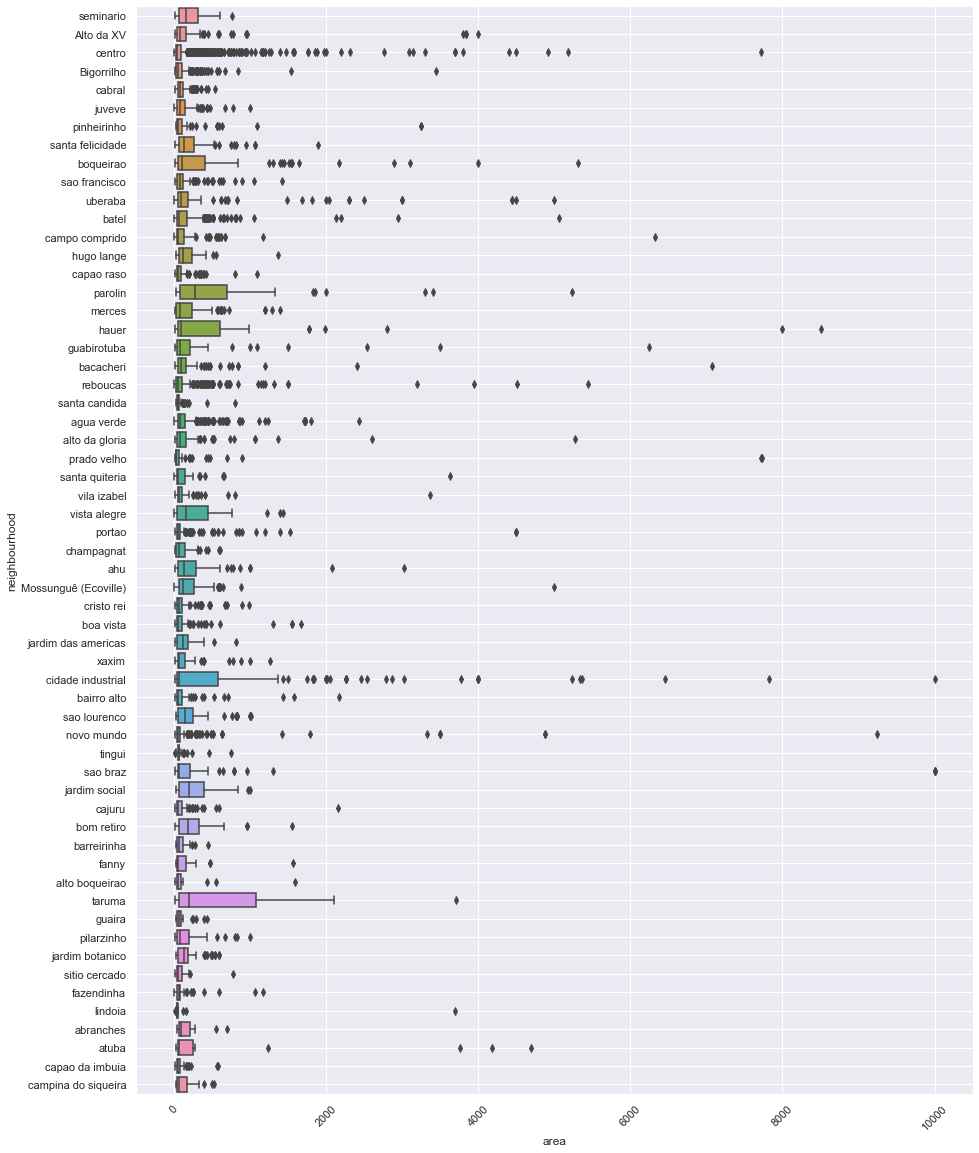

In [11]:
#fig, ax = plt.subplots(figsize=(10,8))
#sns.boxplot(data=properties["price"], ax=ax)

fig, ax = plt.subplots(figsize=(15,20))
sns.boxplot(data=properties[["neighbourhood", "price"]], x="price", y="neighbourhood", ax=ax)
ax.grid(True)
plt.xticks(rotation=45)

# Removendo outliers de área

In [12]:
properties = properties.loc[properties["area"] != 0]
properties = properties[np.abs(zscore(properties["area"])) < 1.5]


properties["area"].describe()

count    9504.000000
mean      116.165930
std       140.990194
min         1.000000
25%        39.000000
50%        61.000000
75%       121.250000
max       939.000000
Name: area, dtype: float64

<AxesSubplot:>

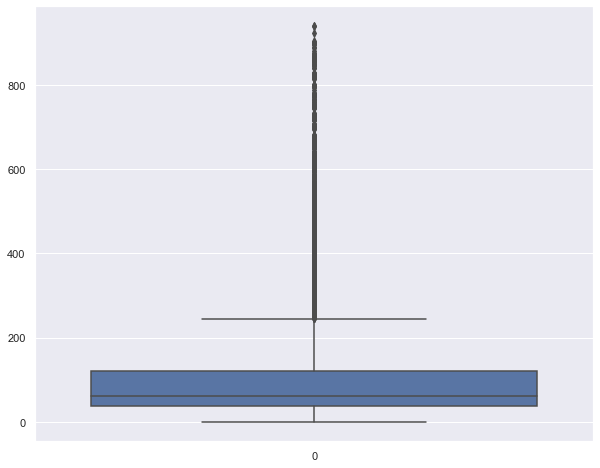

In [13]:
fig, ax = plt.subplots(figsize=(10,8))
sns.boxplot(data=properties["area"], ax=ax)

In [14]:
print("Total de outliers filtrados: ",round((1-(properties["price"].count()/total_properties))*100,2),"%")


Total de outliers filtrados:  16.03 %


# Entendendo correlações

<AxesSubplot:>

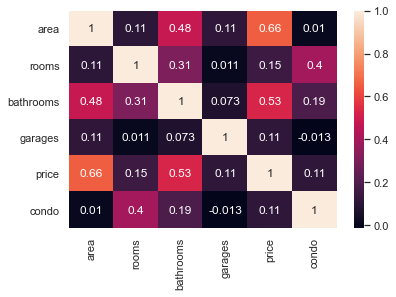

In [15]:
sns.heatmap(properties[["area","rooms","bathrooms","garages","price","condo"]].corr(), annot=True)


Text(0.5, 1.0, 'Area vs Price')

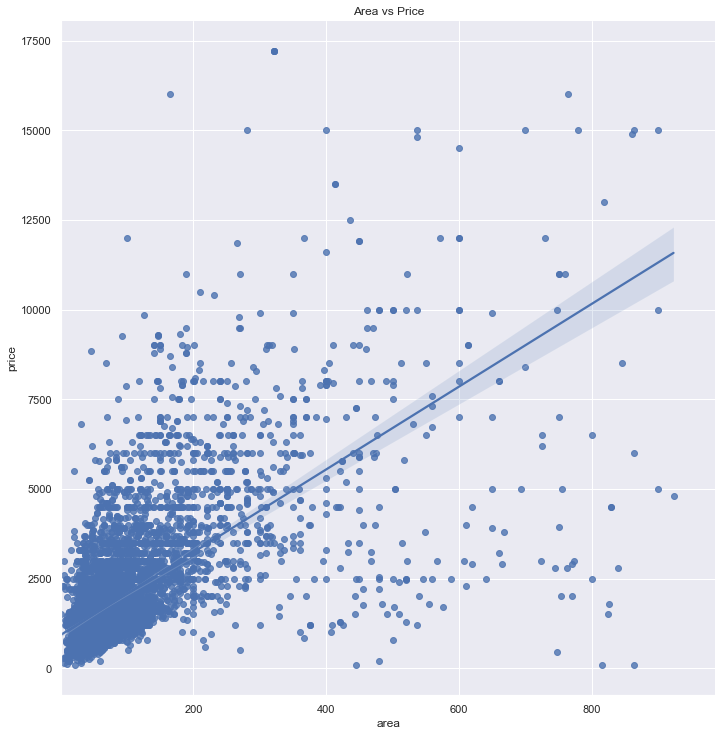

In [16]:
#prices_by_neighborhood = properties.groupby(['neighbourhood'])['price'].count()
#prices_by_neighborhood = prices_by_neighborhood.reset_index()


sns.lmplot(x='area', y='price', data=properties, height=10)
ax = plt.gca()
ax.set_title("Area vs Price")


# Verificando distribuições numéricas

<AxesSubplot:xlabel='price', ylabel='Count'>

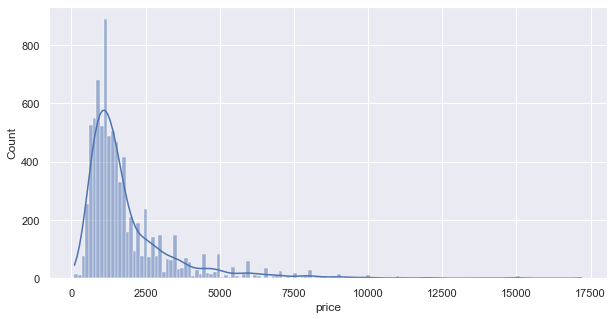

In [17]:
fig, ax = plt.subplots(figsize=(10,5))
sns.histplot(data=properties, x="price", kde=True, ax=ax)

<AxesSubplot:xlabel='area', ylabel='Count'>

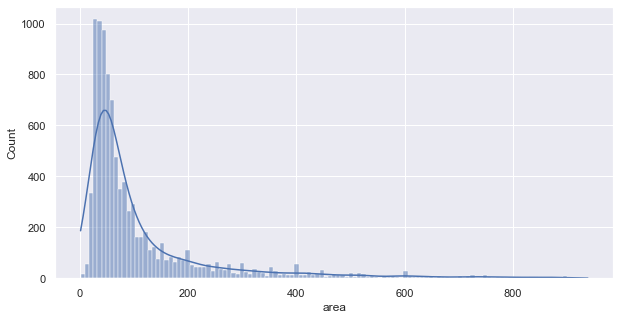

In [18]:
fig, ax = plt.subplots(figsize=(10,5))
sns.histplot(data=properties, x="area", kde=True, ax=ax)

In [13]:
#outiliers condominio
#properties = properties[np.abs(zscore(properties["condo"])) < 3]
#sns.histplot(data=properties, x="condo", kde=True)

<AxesSubplot:title={'center':'Number of apartments vs neighbourhood'}, xlabel='count', ylabel='neighbourhood'>

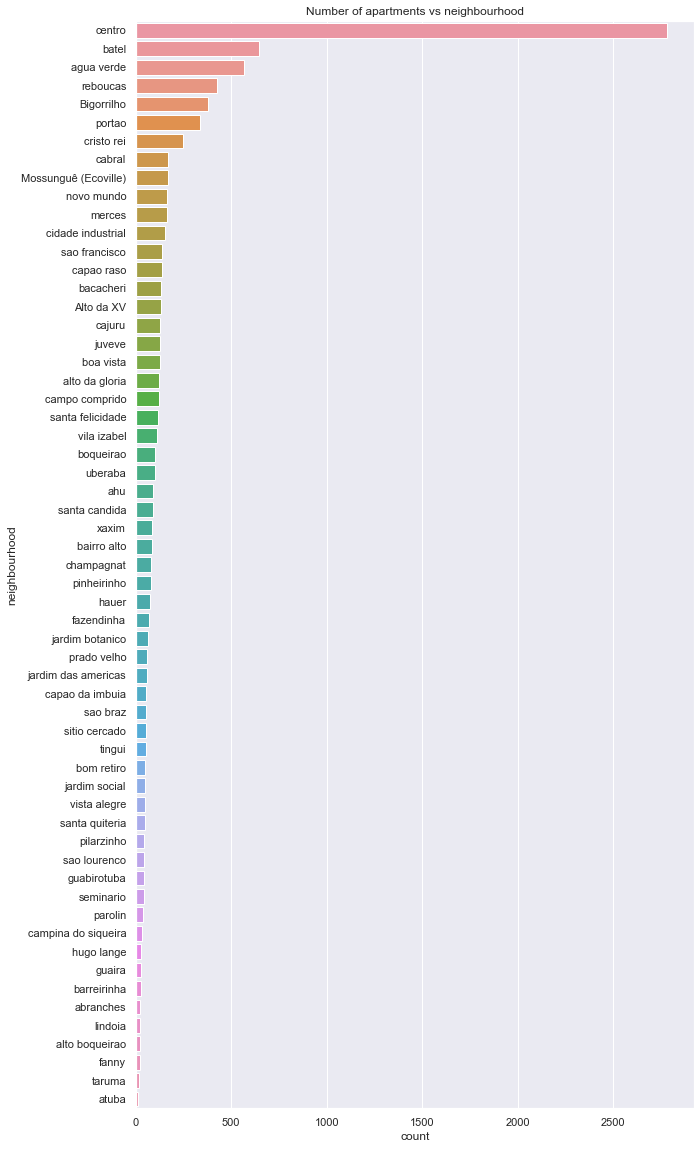

In [19]:
fig, ax = plt.subplots(figsize=(10,20))
ax.set_title("Number of apartments vs neighbourhood")
sns.countplot(data=properties, y="neighbourhood", ax=ax, order=properties['neighbourhood'].value_counts().index)